In [2]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms
# 3rd Party Libraries
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import scipy.ndimage

In [4]:
data_manager = DataManager()

db, db_files = data_manager.load_data("./data/BBDD/",".jpg", desc = "Loading BBDD Data...")
qsd1_w2, qsd1_w2_files = data_manager.load_data("./data/qsd1_w2/",".jpg", desc = "Loading qsd1_w2 Data...")

Loading qsd1_w2 Data...: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 173.36it/s]

./data/BBDD/ read: 287 images


./data/qsd1_w2/ read: 30 images


In [229]:
with open("./data/qsd1_w2/text_boxes.pkl", "rb") as file:
    gt_boxes = pickle.load(file)
    print(gt_boxes)


[[[array([101,   6]), array([101, 107]), array([571, 107]), array([571,   6])]], [[array([68, 18]), array([68, 97]), array([384,  97]), array([384,  18])]], [[array([ 506, 1797]), array([ 506, 1882]), array([1106, 1882]), array([1106, 1797])]], [[array([576, 106]), array([576, 235]), array([1176,  235]), array([1176,  106])]], [[array([ 90, 523]), array([ 90, 556]), array([509, 556]), array([509, 523])]], [[array([54, 22]), array([54, 55]), array([307,  55]), array([307,  22])]], [[array([47,  1]), array([ 47, 123]), array([265, 123]), array([265,   1])]], [[array([526, 149]), array([526, 212]), array([1126,  212]), array([1126,  149])]], [[array([ 44, 350]), array([ 44, 379]), array([250, 379]), array([250, 350])]], [[array([ 38, 269]), array([ 38, 309]), array([216, 309]), array([216, 269])]], [[array([101, 513]), array([101, 556]), array([574, 556]), array([574, 513])]], [[array([31, 10]), array([31, 41]), array([179,  41]), array([179,  10])]], [[array([49, 17]), array([49, 43]), a

In [7]:
def text_removal(image:np.ndarray,num_images:int):
    
    #Transform to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Defining the kernels to use
    filterSize =(12, 12)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, 
                                   filterSize)
    
    #Applying tophat and blackhat morph operators
    tophat_img = cv2.morphologyEx(img, 
                              cv2.MORPH_TOPHAT,
                              kernel)
    blackhat_img = cv2.morphologyEx(img, 
                              cv2.MORPH_BLACKHAT,
                              kernel)
    #Defining the kernels to use
    filterSize =(3, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, 
                                   filterSize)
    #Adding the results of tophat and blackhat morph operators and thresholding 
    #to get the letters that have the most intensity
    mean = tophat_img/2 +blackhat_img/2
    hat = np.uint8(mean>70)
    
    #Opening filter to remove little artifacts
    opening = cv2.morphologyEx(hat, cv2.MORPH_OPEN, kernel,iterations = 1)

    #Defining the kernels to use
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80,18 ))

    # Applying dilation on the threshold image
    dilation = cv2.dilate(opening, rect_kernel, iterations = 1)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)
    
    bounded = np.zeros((img.shape))
    
    #Loop to get the contour with the greatest area
    if num_images==1:
        area = 0
        for cnt in contours:
            area_1 = cv2.contourArea(cnt)
            if area_1 >= area:
                area = area_1
                x, y, w, h = cv2.boundingRect(cnt)
        
        rect = cv2.rectangle(image, (x,y),(x+w,y+h) , (0,0,0), -1)
        
        return image
    if num_images==2:
        area_1 = 0
        area_2 = 0
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area >= area_1:
                area_1 = area
                x1, y1, w1, h1 = cv2.boundingRect(cnt)
            if area >= area_2:
                area_2 = area
                x2, y2, w2, h2 = cv2.boundingRect(cnt)
        
        rect = cv2.rectangle(image, (x1,y1),(x1+w1,y1+h1) , (0,0,0), -1)
        rect = cv2.rectangle(image, (x2,y2),(x2+w2,y2+h2) , (0,0,0), -1)
        return image
    

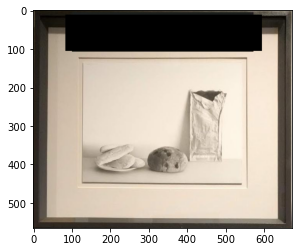

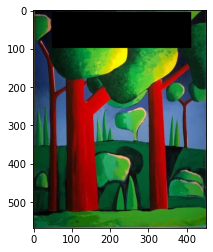

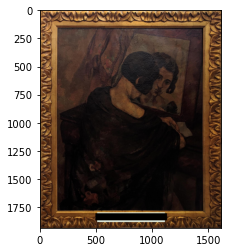

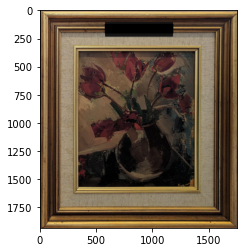

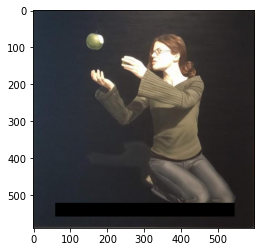

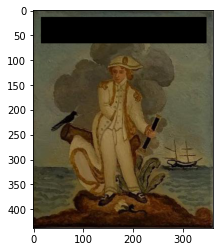

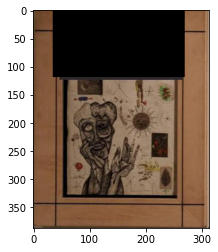

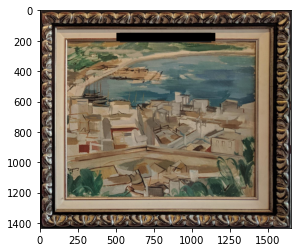

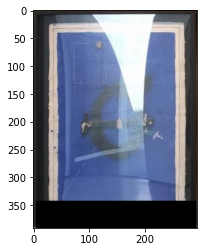

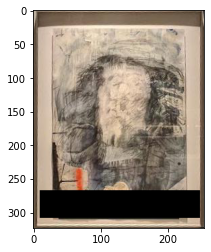

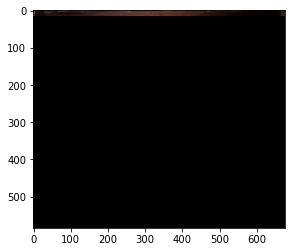

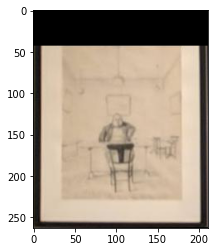

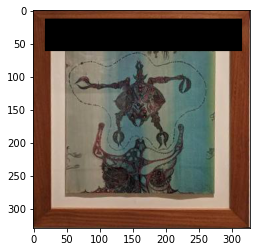

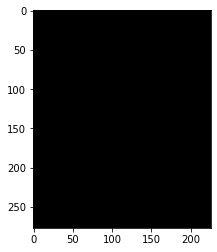

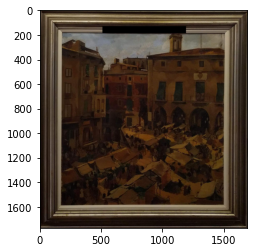

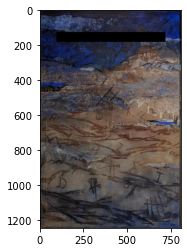

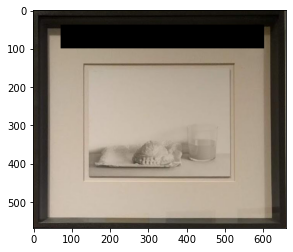

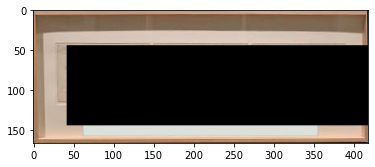

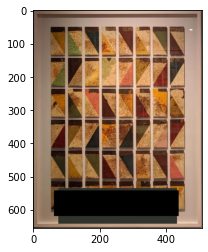

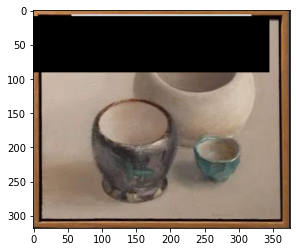

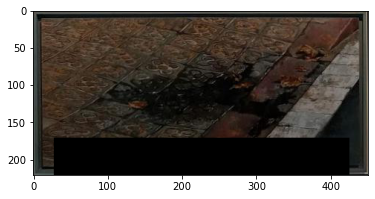

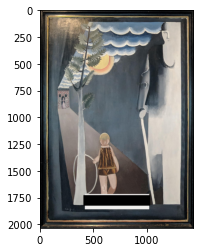

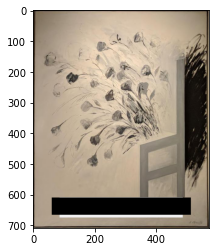

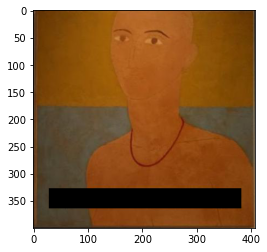

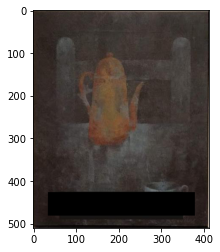

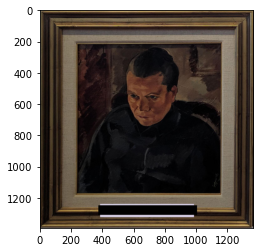

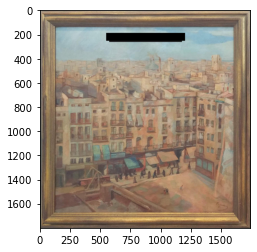

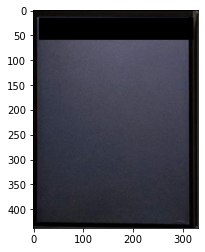

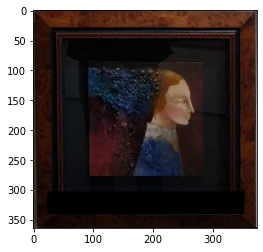

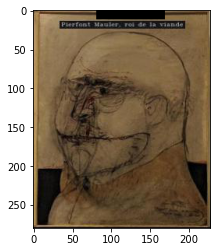

In [9]:
iou=0
for img in qsd1_w2:
    masked = text_removal(img,1)
    plt.figure()
    plt.imshow(masked)
    plt.show()